# GRADCAM

In [1]:
import sys
import h5py
import tensorflow as tf

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [2]:
print('...')
print('--> VERSOES')
print("Versao python:", sys.version)
print("Versao de tensorflow:", tf.__version__)
print("Versao de Numpy:", np.__version__)

...
--> VERSOES
Versao python: 3.7.11 (default, Jul 27 2021, 09:42:29) [MSC v.1916 64 bit (AMD64)]
Versao de tensorflow: 2.3.0
Versao de Numpy: 1.20.0


In [3]:
def GradcamInterpreter(model, x_img, last_conv_layer_name):
    '''
    Aplica o método Kernel SHAP (Local Interpreter) em uma imagem aplicada no modelo classificador.
    
    Args.
        model: modelo treinado
        x_img: (1, im_height, im_width, 1) imagem a ser analisada
        last_conv_layer_name: str com o nome da camada convolucional que deveja analisar
            
    Returns.
        Plots do resultado do gradcam
        
    '''
    
    # Cria gradcam heatmap
    # ---------------------------------------
    def getGradcam(img_array, grad_model):
        '''
        Cria um grad-cam heatmap dado um modelo e uma camada contida no modelo


        Args:
          img_array: (None x img_width x img_height x 3) numpy array
          grad_model: class 'keras.engine.functional.Functional'
                      tf.keras.models.Model(inputs=[model.inputs],
                                            outputs=[model.get_layer(last_conv_layer_name).output, model.output])


        Returns 
          jet_heatmap: (img_width x img_height x 3) float32 numpy array that is the heatmap needed to superimpose in 
          the original image
        '''

        pred_index=None

        # Computamos o gradiente da melhor (top) classe predita para a imagem
        # de entrada com relação as ativações da última camada convolucional
        with tf.GradientTape() as tape:
            last_conv_layer_output, preds = grad_model(img_array)

            if pred_index is None:
                pred_index = tf.argmax(preds[0])

            class_channel = preds[:, pred_index] # loss associated with the specific class index

        # Esse é o gradiente do neuronio de saída (top predicted or chosen)
        # com relação ao mapa de caracteristica de saída da ultima camada convolucional
        grads = tape.gradient(class_channel, last_conv_layer_output)
        # tape.gradient calculate the gradient of some target (often a loss) relative
        # to some source (often the model's variables)


        # Ou seja, até aqui nós rodamos a entrada no modelo, pegamos a saída da camada e a perda.
        # Depois, achamos o gradiente da saída da camada desejada com relação a perda do modelo.

        # Esse é um vetor onde cada entrada é a intensidade média do gradiente
        # sobre um canal de um mapa de característica específico
        pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

        # Nós multiplicamos cada canal no vetor do mapa de características acima pelo
        # "quão importante aquele canal é" com relação a melhor classe predita, então
        # somamos todos os canais para obter o heatmap
        last_conv_layer_output = last_conv_layer_output[0]
        heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
        heatmap = tf.squeeze(heatmap) # Remove eixos com tamanho 1

        # For visualization purpose, we will also normalize the heatmap between 0 & 1
        heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)

        # Rescale heatmap to a range 0-255
        heatmap = np.uint8(255 * heatmap)

        # Use jet colormap to colorize heatmap
        jet = cm.get_cmap("jet")

        # Use RGB values of the colormap
        jet_colors = jet(np.arange(256))[:, :3]
        jet_heatmap = jet_colors[heatmap]

        # Create an image with RGB colorized heatmap
        jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
        jet_heatmap = jet_heatmap.resize((img_array.shape[2], img_array.shape[1]))
        jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)
        
        plt.figure(figsize=(10,5))
        plt.imshow(jet_heatmap.astype(np.uint8))
        plt.title('Gradcam mask')
        plt.axis('off')

        return jet_heatmap
    

    # Remove last layer's softmax
    model.layers[-1].activation = None

    # Carrega entradas/saídas do modelo para pegar o gradiente da imagem de entrada até a camada desejada
    grad_model = tf.keras.models.Model(inputs=[model.inputs],
                                       outputs=[model.get_layer(last_conv_layer_name).output, model.output])

    # Gerar heatmap do Grad-Cam
    jet_heatmap = getGradcam(x_img, grad_model)
    
    fig = plt.figure(figsize=(10,5))
    ax1 = fig.add_subplot(2, 1, 1)
    ax1.imshow(x_img[0], cmap='gray')
    ax1.set_title("Original Image\n Class: FA")
    ax1.axis('off')

    ax2 = fig.add_subplot(2, 1, 2)
    ax2.imshow(x_img[0], cmap='gray')
    ax2.imshow(jet_heatmap.astype(np.uint8), cmap='jet', alpha=0.5) # overlap
    ax2.set_title("Grad-Cam Image")
    ax2.axis('off')

    plt.tight_layout()
    plt.show()
    fig.savefig('ecgD2_Gradcam_classFA.jpg')

## Image to be analyzed:  35
## Image prediction (NORMAL = 0 | FA = 1):  1


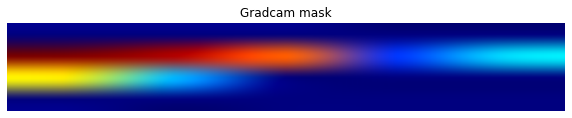

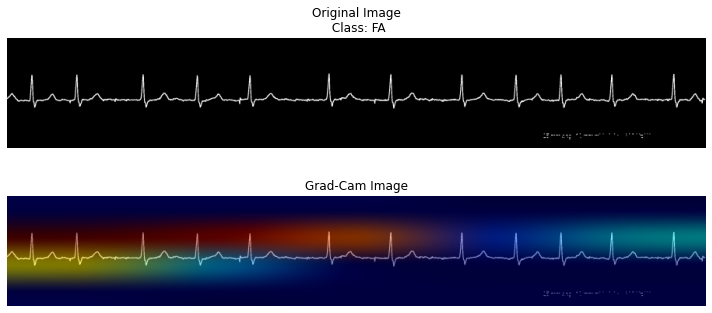

In [4]:
if __name__ == '__main__':
    # Carregando modelo de classificação
    model = tf.keras.models.load_model('modelD2long.h5', compile=False)
    #model.summary()

    # Abrindo dataset de exemplo
    h5 = h5py.File('ecgD2longImgs.h5', 'r') # Open file
    data = h5['2d'] # D2 images
    
    # LOAD IMAGE
    # Artigo: normal (3) | fa (35)
    idx = 35

    x_img = data[idx] # FA
    x_img = np.expand_dims(x_img, axis = 0) # input shape nedded for the model

    print('## Image to be analyzed: ', idx)
    print('## Image prediction (NORMAL = 0 | FA = 1): ', int(model.predict(x_img)))
    
    last_conv_layer_name = "conv2d_11"
    
    # Aplica interpretador
    GradcamInterpreter(model, x_img, last_conv_layer_name)
    
    #obs. se nsamples for menor que num_superpixels é possível que dê erro